# Analisi dei Risultati Referendari: Voto, Quorum e Partecipazione

Questo notebook analizza, con un modellino semplificato, l'esito del referendum dell'8-9 giugno 2025 tenendo conto dei tassi di partecipazione al voto stimati tra favorevoli, contrari e indifferenti. Visualizza graficamente l’esito (Sì, No, Nullo) in funzione della percentuale di partecipazione dei gruppi.

Sono presenti due sezioni principali:
1. **Analisi basata su dati reali**: impiega i dati ufficiali di uno dei cinque quesiti referendari (solo seggi italiani, no voti dal'estero).
2. **Analisi teorica**: visualizza uno scenario ipotetico assumendo un certo livello di favorevoli e indifferenti.

---

**Autore**: Luca Brusasco  
**Email**: lbrusasco@gmail.com\
**Copyright**: © 2025 Luca Brusasco  
**Licenza**: CC BY 4.\
**Link**: https://github.com/BrusXVII/modellino_referendum_2025.git


## 🧪 Gioca con i parametri!

Questo notebook è pensato per sperimentare facilmente con il modello.  
Puoi modificare alcuni parametri chiave per vedere come cambiano l'affluenza, l’esito del referendum, e il rispetto del quorum:

### 📊 Sezione con dati reali
- `quesito` → per analizzare un altro quesito referendario (da 1 a 5)
- `beta` → percentuale stimata di favorevoli che vanno a votare
- `perc_indifferenti` → quota stimata della popolazione che si astiene per disinteresse

### 🔬 Scenario teorico
- `s` → supporto teorico al "Sì" nella popolazione
- `perc_indifferenti` → astensione per disinteresse
- `perc_bianche_nulle` → percentuale di schede bianche o nulle tra i votanti
- `q` → soglia di quorum (di default 50% + 1 elettore, ma puoi modificarla)

> 💡 Non serve toccare nulla del codice interno: basta cambiare i numeri in cima alle celle e il grafico si aggiorna da solo.

---

✏️ Se vuoi, puoi anche aggiungere i tuoi dati reali o simulare casi limite (tipo tutti i contrari che votano e i favorevoli che si astengono).

📬 Feedback, idee o modifiche sono sempre benvenuti.




### 1. Analisi basata su dati reali (8-9 giugno 2025):

Stima s (favorevoli): 0.2180
Stima n (contrari):   0.5257
Quota indifferenti:   0.2500
Quota bianche/nulle:  0.0064
Beta (favorevoli che hanno votato):  0.90
Alpha (contrari che hanno votato):   0.1966


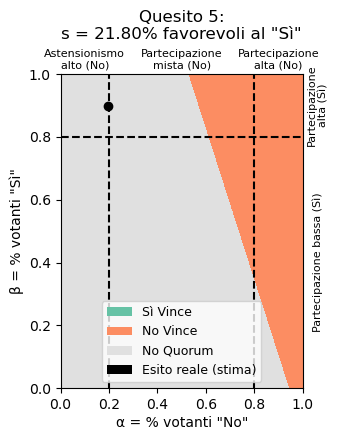

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# === SELEZIONE QUESITO ===
# Scegli il quesito referendario da analizzare (da 1 a 5)
quesito = 5

# === DATI REALI ===
# Totale aventi diritto al voto
totale_elettori = 45997941

# Dati ufficiali per ciascun quesito: (numero voti Sì, numero voti No, numero schede bianche + nulle)
dati_quesiti = {
    1: {'sì': 12249432, 'no': 1504290, 'bn': 313075},
    2: {'sì': 12031603, 'no': 1702707, 'bn': 325017},
    3: {'sì': 12167755, 'no': 1495899, 'bn': 343770},
    4: {'sì': 11952567, 'no': 1729995, 'bn': 321783},
    5: {'sì': 9023526,  'no': 4754292, 'bn': 293445}
}

# Controllo che il quesito sia valido
if quesito not in dati_quesiti:
    raise ValueError("Quesito deve essere un numero tra 1 e 5.")

# Estrae i voti Sì e No per il quesito scelto
dati = dati_quesiti[quesito]
voti_sì = dati['sì']
voti_no = dati['no']
bianche_nulle = dati['bn']

voti_validi = voti_sì + voti_no
votanti = voti_validi + bianche_nulle

# === PARAMETRI MODELLO ===
perc_indifferenti = 0.25  # Percentuale stimata di popolazione indifferente
beta = 0.90  # Percentuale stimata dei favorevoli che ha effettivamente votato

# === CALCOLO DEI GRUPPI ===

# Numero di indifferenti stimati
indifferenti = perc_indifferenti * totale_elettori

# Resto della popolazione: chi ha un’opinione (favorevoli o contrari)
non_indifferenti = totale_elettori - indifferenti

# Stima del numero totale di favorevoli (assumendo che solo una percentuale beta abbia votato)
num_favorevoli = voti_sì / beta
s = num_favorevoli / totale_elettori  # % favorevoli sulla popolazione totale

# La popolazione si divide in: favorevoli (s), contrari (n), indifferenti (i), e chi ha votato senza scegliere (b)
# Calcoliamo la quota di contrari residua
quota_bn = bianche_nulle / totale_elettori
n = 1 - s - perc_indifferenti - quota_bn  # % contrari nella popolazione

# Numero assoluto di contrari
num_contrari = n * totale_elettori

# alpha è la percentuale di contrari che ha votato
alpha = voti_no / num_contrari

# soglia quorum
quorum_assoluto = (totale_elettori // 2) + 1
q = quorum_assoluto / totale_elettori

# === DEBUG OUTPUT ===
quota_bn = bianche_nulle / totale_elettori  # % di schede bianche/nulle sulla popolazione
print(f"Stima s (favorevoli): {s:.4f}")
print(f"Stima n (contrari):   {n:.4f}")
print(f"Quota indifferenti:   {perc_indifferenti:.4f}")
print(f"Quota bianche/nulle:  {quota_bn:.4f}")
print(f"Beta (favorevoli che hanno votato):  {beta:.2f}")
print(f"Alpha (contrari che hanno votato):   {alpha:.4f}")

# === GRIGLIA ===
# Qui si costruisce una mappa degli esiti del referendum in funzione della partecipazione
# Beta (Y) = % favorevoli che votano, Alpha (X) = % contrari che votano
num_points = 1000
beta_vals = np.linspace(0, 1, num_points)
alpha_vals = np.linspace(0, 1, num_points)
outcome_matrix = np.empty((num_points, num_points), dtype=object)

# Calcolo dell’esito (Sì, No, Nullo) per ogni combinazione di alpha e beta
for i, beta_ in enumerate(beta_vals):
    for j, alpha_ in enumerate(alpha_vals):
        voti_sì = beta_ * s * totale_elettori
        voti_no = alpha_ * n * totale_elettori
        affluenza = voti_sì + voti_no + bianche_nulle

        # Se affluenza < quorum, il referendum è nullo (quorum non raggiunto)
        if affluenza < q * totale_elettori:
            outcome = 'Nullo'
        else:
            total_validi = voti_sì + voti_no
            pct_sì = voti_sì / total_validi
            outcome = 'Sì' if pct_sì > 0.5 else 'No'

        outcome_matrix[i, j] = outcome

# === PLOT ===
# Colori associati agli esiti
color_map = {'Sì': '#66c2a5', 'No': '#fc8d62', 'Nullo': '#e0e0e0'}
value_map = {'Sì': 0, 'No': 1, 'Nullo': 2}

# Ricava gli esiti effettivamente presenti nella matrice
outcomes_presenti = sorted(set(value for row in outcome_matrix for value in row))
colori_usati = [color_map[o] for o in outcomes_presenti]
cmap = ListedColormap(colori_usati)

# Mappa ogni stringa ('Sì', 'No', 'Nullo') a un valore numerico per la visualizzazione
reverse_value_map = {o: i for i, o in enumerate(outcomes_presenti)}
numeric_matrix = np.vectorize(reverse_value_map.get)(outcome_matrix)

# === VISUALIZZAZIONE ===
fig, ax = plt.subplots(figsize=(3.5, 4.5))

# Heatmap: alpha (X), beta (Y)
im = ax.imshow(numeric_matrix, cmap=cmap, origin='lower', extent=[0, 1, 0, 1], aspect='auto')

# Etichette assi
ax.set_xlabel('α = % votanti "No"', fontsize=10, labelpad=3)
ax.set_ylabel('β = % votanti "Sì"', fontsize=10, labelpad=3)
ax.set_title(f'Quesito {quesito}:\ns = {s:.2%} favorevoli al "Sì"', fontsize=12, pad=25)

# Linee guida verticali/orizzontali
ax.axvline(0.2, color='black', linestyle='--')  # α = 20%
ax.axvline(0.8, color='black', linestyle='--')  # α = 80%
ax.axhline(0.8, color='black', linestyle='--')  # β = 80%

# Annotazioni testuali (suggerimenti visivi)
ax.text(0.1, 1.01, 'Astensionismo\nalto (No)', ha='center', va='bottom', fontsize=8)
ax.text(0.5, 1.01, 'Partecipazione\nmista (No)', ha='center', va='bottom', fontsize=8)
ax.text(0.9, 1.01, 'Partecipazione\nalta (No)', ha='center', va='bottom', fontsize=8)
ax.text(1.06, 0.4, 'Partecipazione bassa (Sì)', ha='center', va='center', fontsize=8, rotation=90)
ax.text(1.06, 0.9, 'Partecipazione\nalta (Sì)', ha='center', va='center', fontsize=8, rotation=90)

# Punto reale stimato (valori calcolati di alpha e beta)
ax.plot(alpha, beta, 'ko', markersize=6, label='Esito reale')

# Legenda dei colori
legend_elements = [
    Patch(facecolor=color_map['Sì'], label='Sì Vince'),
    Patch(facecolor=color_map['No'], label='No Vince'),
    Patch(facecolor=color_map['Nullo'], label='No Quorum'),
    Patch(facecolor='black', label='Esito reale (stima)')
]
ax.legend(handles=legend_elements, loc='lower center', fontsize=9, frameon=True)

# Salvataggio
#plt.tight_layout()
#plt.savefig(f'referendum_heatmap_quesito_{quesito}.png', dpi=300, bbox_inches='tight', pad_inches=0.4)
#plt.show()


### 2. Analisi teorica:

Stima s (favorevoli): 0.4000
Stima n (contrari):   0.3300
Quota indifferenti:   0.2500
Quota bianche/nulle:  0.0200


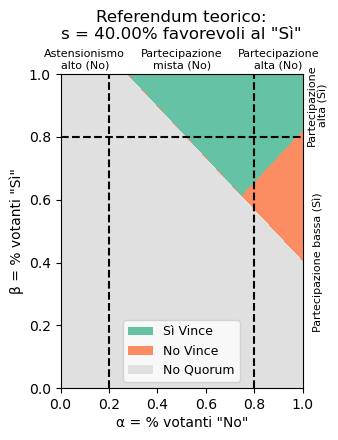

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# === PARAMETRI TEORICI ===
# Scenario ipotetico con suddivisione della popolazione
perc_indifferenti = 0.25                                # % della popolazione che non vota per disinteresse
perc_bianche_nulle = 0.02                               # % di schede bianche e nulle tra i votanti
s = 0.40                                                # % favorevoli al "Sì"
n = 1 - s - perc_indifferenti - perc_bianche_nulle      # % contrari
q = 0.5000001                                           # Quorum: serve almeno il 50%+1 di affluenza

# === DEBUG OUTPUT ===
print(f"Stima s (favorevoli): {s:.4f}")
print(f"Stima n (contrari):   {n:.4f}")
print(f"Quota indifferenti:   {perc_indifferenti:.4f}")
print(f"Quota bianche/nulle:  {perc_bianche_nulle:.4f}")

# === GRIGLIA ===
# Simula ogni combinazione di partecipazione favorevoli/contrari
num_points = 1000
beta_vals = np.linspace(0, 1, num_points)    # % favorevoli che votano
alpha_vals = np.linspace(0, 1, num_points)   # % contrari che votano

outcome_matrix = np.empty((num_points, num_points), dtype=object)

# === SIMULAZIONE ===
for i, beta in enumerate(beta_vals):
    for j, alpha in enumerate(alpha_vals):
        voti_sì = beta * s
        voti_no = alpha * n
        voti_validi = voti_sì + voti_no

        # Calcolo delle schede bianche/nulle come % dei voti validi
        voti_bn = perc_bianche_nulle * voti_validi / (1 - perc_bianche_nulle)
        affluenza = voti_validi + voti_bn

        # Se affluenza < quorum: esito nullo
        if affluenza < q:
            outcome = 'Nullo'
        else:
            # L'esito tra "Sì" e "No" si basa solo sui voti validi
            outcome = 'Sì' if voti_sì > voti_no else 'No'

        outcome_matrix[i, j] = outcome

# === PLOT ===
color_map = {'Sì': '#66c2a5', 'No': '#fc8d62', 'Nullo': '#e0e0e0'}
value_map = {'Sì': 0, 'No': 1, 'Nullo': 2}
numeric_matrix = np.vectorize(value_map.get)(outcome_matrix)
cmap = ListedColormap([color_map['Sì'], color_map['No'], color_map['Nullo']])

fig, ax = plt.subplots(figsize=(3.5, 4.5))
im = ax.imshow(numeric_matrix, cmap=cmap, origin='lower', extent=[0, 1, 0, 1], aspect='auto')

# Etichette e titolo
ax.set_xlabel('α = % votanti "No"', fontsize=10, labelpad=3)
ax.set_ylabel('β = % votanti "Sì"', fontsize=10, labelpad=3)
ax.set_title(f'Referendum teorico:\ns = {s:.2%} favorevoli al "Sì"', fontsize=12, pad=25)

# Linee guida di riferimento
ax.axvline(0.2, color='black', linestyle='--')
ax.axvline(0.8, color='black', linestyle='--')
ax.axhline(0.8, color='black', linestyle='--')

# Annotazioni visive
ax.text(0.1, 1.01, 'Astensionismo\nalto (No)', ha='center', va='bottom', fontsize=8)
ax.text(0.5, 1.01, 'Partecipazione\nmista (No)', ha='center', va='bottom', fontsize=8)
ax.text(0.9, 1.01, 'Partecipazione\nalta (No)', ha='center', va='bottom', fontsize=8)
ax.text(1.06, 0.4, 'Partecipazione bassa (Sì)', ha='center', va='center', fontsize=8, rotation=90)
ax.text(1.06, 0.9, 'Partecipazione\nalta (Sì)', ha='center', va='center', fontsize=8, rotation=90)

# Legenda
legend_elements = [
    Patch(facecolor=color_map['Sì'], label='Sì Vince'),
    Patch(facecolor=color_map['No'], label='No Vince'),
    Patch(facecolor=color_map['Nullo'], label='No Quorum')
]
ax.legend(handles=legend_elements, loc='lower center', fontsize=9, frameon=True)

# Salvataggio (opzionale)
#plt.tight_layout()
#plt.savefig(f'referendum_heatmap_teorico_s_{s}.png', dpi=300, bbox_inches='tight', pad_inches=0.4)
#plt.show()


---

## ✍️ Note finali

Questo notebook è pensato solo come spunto esplorativo: si basa su dati pubblici e assunzioni semplificate che possono ovviamente essere migliorate.

Se hai idee, critiche o vuoi contribuire con miglioramenti al modellino, sentiti liber* di modificarlo o scrivermi!

---
